In [58]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize 
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [60]:
directory = "./synthetic-data-10m"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.split(".")[-1]=="txt"]

print(files)

['rx_times.txt', 'background.txt', 'target_30.txt', 'target_45.txt', 'target_0.txt', 'rx_locs.txt', 'target_15.txt']


In [61]:
files.remove("rx_locs.txt")
rx_locs = np.loadtxt(f"{directory}/rx_locs.txt")

files.remove("rx_times.txt")
rx_times = np.loadtxt(f"{directory}/rx_times.txt")

In [62]:
dobs_dict = {}

for f in files: 
    key = f.split(".")[0]
    dobs_dict[key] = np.loadtxt(f"{directory}/{f}")

In [63]:
data_dict = {}

for key, value in dobs_dict.items(): 
    source_list = []
    for i in range(rx_locs.shape[0]): 
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)
    
    full_survey = tdem.Survey(source_list)

    data_dict[key] = Data(survey=full_survey, dobs=value, relative_error=0.05)

In [64]:
mesh = discretize.load_mesh(f"{directory}/treemesh.json")

/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/utils/io_utils.py:39: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  data = cls(**jsondict)


In [65]:
inv_directory = f"./synthetic-invs-3d-finer"
files = [f for f in os.listdir(inv_directory) if os.path.isfile(os.path.join(inv_directory, f)) and f.split(".")[-1]=="npy"]
pkl_files = [f for f in os.listdir(inv_directory) if os.path.isfile(os.path.join(inv_directory, f)) and f.split(".")[-1]=="pkl"]

In [66]:
f = files[0]

In [67]:
recovered_models = {}

for f in files: 
    key = "_".join(f.split("_")[:2])
    recovered_models[key] = np.load(f"{inv_directory}/{f}")

In [68]:
inv_results = {}
for file in pkl_files: 
    key = "_".join(file.split("_")[:2])
    with open(f"{inv_directory}/{file}", "rb") as f:
        inv_results[key] = pickle.load(f)

In [69]:
active_cells_map = maps.InjectActiveCells(mesh, mesh.cell_centers[:, 2]<0, value_inactive=np.log(1e-8))

In [70]:
recovered_models.keys()

dict_keys(['target_30', 'target_0', 'target_45', 'target_15'])

(array([1.6000e+01, 8.0000e+00, 2.4000e+01, 2.2000e+01, 1.2160e+03,
        4.3500e+04, 3.0286e+04, 5.4480e+03, 8.3200e+02, 4.8000e+01]),
 array([-15.91685102, -14.24587531, -12.5748996 , -10.90392389,
         -9.23294818,  -7.56197247,  -5.89099676,  -4.22002106,
         -2.54904535,  -0.87806964,   0.79290607]),
 <BarContainer object of 10 artists>)

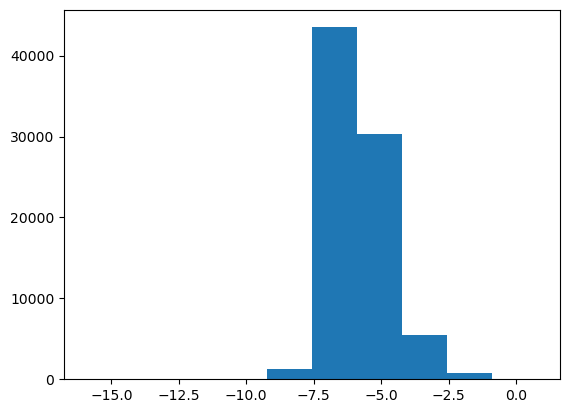

In [92]:
key = "target_0"
plt.hist(recovered_models[key])

In [93]:
tmp = active_cells_map * recovered_models[key]

In [94]:
tmp

array([ -6.2146081 ,  -6.2146081 ,  -6.2146081 , ..., -18.42068074,
       -18.42068074, -18.42068074])

In [95]:
np.log(1e-8)

np.float64(-18.420680743952367)

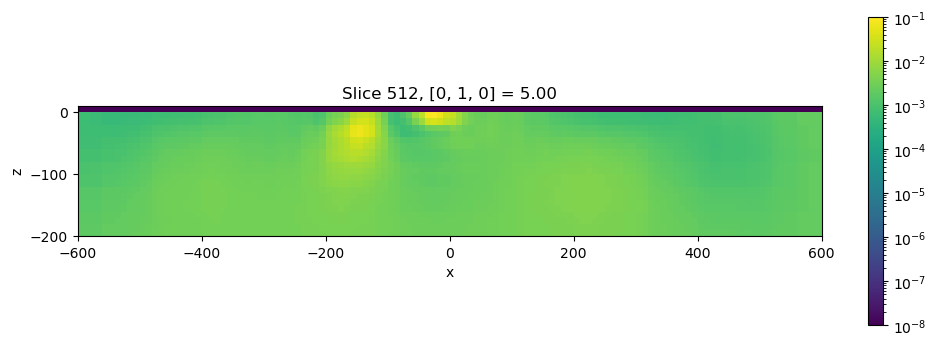

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
key = "target_45"

plt.colorbar(mesh.plot_slice(
    np.exp(active_cells_map * recovered_models[key]), pcolor_opts={"norm":LogNorm(vmin=1e-8, vmax=1e-1)},
    ax=ax,
    ind=512,
    normal="Y"
)[0])

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(-200, 10)
ax.set_aspect(1)

(array([1.6000e+01, 8.0000e+00, 2.4000e+01, 2.2000e+01, 1.2160e+03,
        4.3500e+04, 3.0286e+04, 5.4480e+03, 8.3200e+02, 4.8000e+01]),
 array([-15.91685102, -14.24587531, -12.5748996 , -10.90392389,
         -9.23294818,  -7.56197247,  -5.89099676,  -4.22002106,
         -2.54904535,  -0.87806964,   0.79290607]),
 <BarContainer object of 10 artists>)

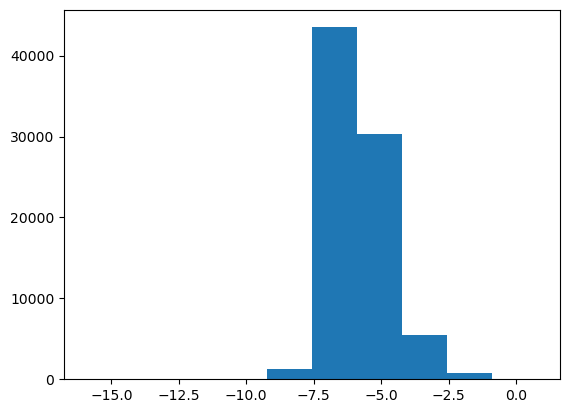

In [86]:
plt.hist(inv_results["target_0"][7]["m"])